**Data science project**

Making medical papers abstracts easier to read.

In [1]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import datetime
import tensorflow_hub as hub

Helper functions

In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  return tf.keras.callbacks.TensorBoard(dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d %H%M%S'))

In [4]:
def preprocess_text_data(document):

  """
  Receives a corpus of text and preprocesses the data.
  Returns a pd.DataFrame with the following columns:
    - line_number: the number of the line in the abstract
    - total_lines: total number of lines in the abstract
    - target: class the line belongs to
    - text: text in line
  """

  abstract_lines = ''
  output_list = []

  for line in document:
    if line.startswith("###"):
      abstract_lines = ''
    elif line.isspace():
      split_text = abstract_lines.splitlines()
      number_of_lines = len(split_text)
      for i, ab_line in enumerate(split_text):
        ab_line_dict = {}
        ab_line_dict['line_number'] = i + 1
        ab_line_dict['total_lines'] = number_of_lines
        ab_line_dict['target'] = ab_line.split('\t')[0]
        ab_line_dict['text'] = ab_line.split('\t')[1]
        output_list.append(ab_line_dict)
    else:
      abstract_lines += line
  
  return output_list

In [5]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

**1. Problem definition**

Abstracts are concise summaries of research papers. Text in an abstract can generally be categorized in one of the following:

1.   Background
2.   Objective
3.   Methods
4.   Results
5.   Conclusions

This project aims to partly replicate the 2017 paper https://arxiv.org/abs/1710.06071, in which the authors used NLP methods to classify lines in an abstract in one of the five categories, making it easier to read.



**2. Determining the necessary data**

To replicate the paper, we'll need the dataset that the authors prepared and worked on. It can be found on the following github repository: https://github.com/Franck-Dernoncourt/pubmed-rct.git.

There are four datasets:



1.   Complete dataset with 200,000 instances
2.   Sample dataset with 20,000 instances

Both datasets come in raw format and with numeric characters replaced with the at sign.


**3. Getting/Inspecting the data**

We'll use the 20k dataset. 

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [7]:
def read_file(filepath):
  with open(filepath, 'r') as read:
    return read.readlines()

In [8]:
root_dir_20k = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

train = read_file(root_dir_20k + '/train.txt')
val = read_file(root_dir_20k + '/dev.txt')
test = read_file(root_dir_20k + '/test.txt')

In [9]:
total_instances = len(train) + len(val) + len(test)
print("Instances in training dataset: {}, {:.1%} of total".format(len(train), len(train) / total_instances))
print("Instances in validation dataset: {}, {:.1%} of total".format(len(val), len(val) / total_instances))
print("Instances in testing dataset: {}, {:.1%} of total".format(len(test), len(test) / total_instances))

Instances in training dataset: 210040, 74.9% of total
Instances in validation dataset: 35212, 12.6% of total
Instances in testing dataset: 35135, 12.5% of total


In [10]:
train[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Strings that start with "###" mark the beginning of a new article. Lines in each article start with the class they belong to and the text separated by the "/t" characters. The end of the article is denoted with "\n". Every line ends with "\n", indicating the beginning of a new line.

This is important to keep in mind when preprocessing and preparing the data to feed to a model.

**4. Data preparation and EDA**

Let's prepare the data to make it easier to understand

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
train_df = pd.DataFrame(preprocess_text_data(train))
val_df = pd.DataFrame(preprocess_text_data(val))
test_df = pd.DataFrame(preprocess_text_data(test))

In [13]:
train_df.head()

,line_number,total_lines,target,text
0,1,12,OBJECTIVE,To investigate the efficacy of @ weeks of dail...
1,2,12,METHODS,A total of @ patients with primary knee OA wer...
2,3,12,METHODS,Outcome measures included pain reduction and i...
3,4,12,METHODS,Pain was assessed using the visual analog pain...
4,5,12,METHODS,Secondary outcome measures included the Wester...


90% of the papers have less than 18 lines

In [14]:
# Check the distribution of the total_lines feature
train_df['total_lines'].describe(percentiles=[x/100 for x in np.arange(10, 100, 10)])

count    180040.000000
mean         12.789136
std           3.236095
min           4.000000
10%           9.000000
20%          10.000000
30%          11.000000
40%          12.000000
50%          12.000000
60%          13.000000
70%          14.000000
80%          15.000000
90%          17.000000
max          31.000000
Name: total_lines, dtype: float64

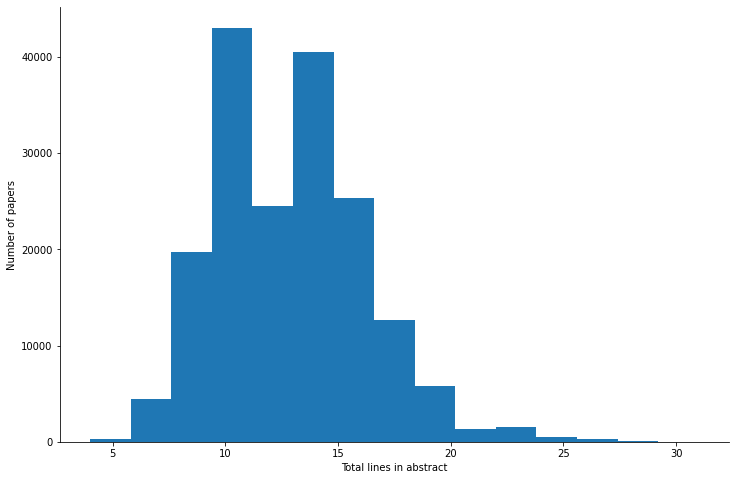

In [15]:
plt.figure(figsize=(12, 8))
ax = train_df['total_lines'].hist(bins=15)
plt.ylabel('Number of papers')
plt.xlabel('Total lines in abstract')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False);

The target variable is imbalanced, with relatively few entries for the OBJECTIVE class

In [16]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [17]:
train_df['target'].value_counts() / train_df['target'].value_counts().sum()

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

There is a clear distinction in the line_number between classes. This is intuitively right because the Objective always comes before the Conclusions, positioning it at the first lines of the article. There is a general order for the presentation of information in an abstract.

We can use this information to engineer some features.

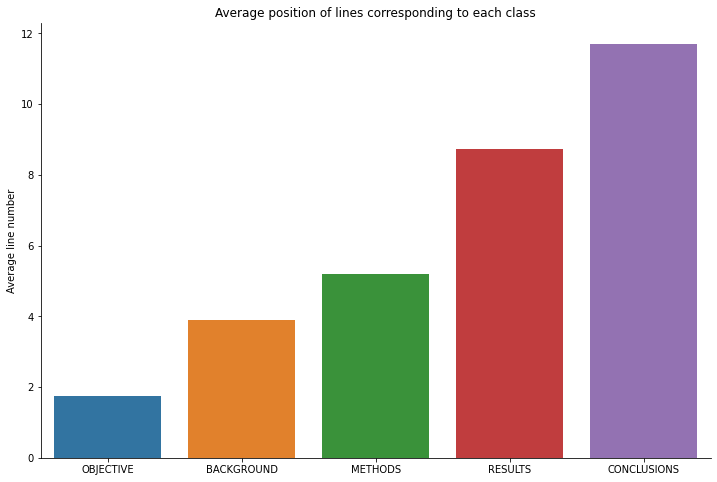

In [18]:
average_target_line = train_df.groupby('target')['line_number'].mean().sort_values(ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=average_target_line.index, y=average_target_line.values)
plt.ylabel('Average line number')
plt.xlabel('')
plt.title('Average position of lines corresponding to each class')
sns.despine()

Let's encode the target variable

In [19]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoder = OneHotEncoder()
train_labels_one_hot = encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(train_df['target'].to_numpy())
labels_val = label_encoder.transform(val_df['target'].to_numpy())
labels_test = label_encoder.transform(test_df['target'].to_numpy())

In [20]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

**5. Training and selecting models**

Before fine-tuning, we will train different models and see which one performs better. Their performance will be compared on the validation dataset.

**5.1 Baseline model**

For our baseline, we will use an sklearn pipeline consisting of a TF-IDF vectorizer to preprocess text data and a MultinomialNB to classify the instances.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [22]:
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinomialnb', MultinomialNB())
])

In [23]:
baseline_model.fit(train_sentences, labels_train)
baseline_model_preds = baseline_model.predict(val_sentences)

In [24]:
baseline_results = calculate_results(y_true=labels_val,
                                     y_pred=baseline_model_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

**5.2 Conv1D model with text vectorizer and word embeddings**

In [25]:
import tensorflow as tf

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)

Before creating the text vectorization layer, let's calculate how many tokens are per line and choose the 95th percentile of the distribution to use as the output_sequence_length in the tf TextVectorization class

In [27]:
# Average sentence length
sentence_length = [len(sentence.split()) for sentence in train_sentences]

# 95th percentile
sequence_length = int(np.percentile(sentence_length, 95))

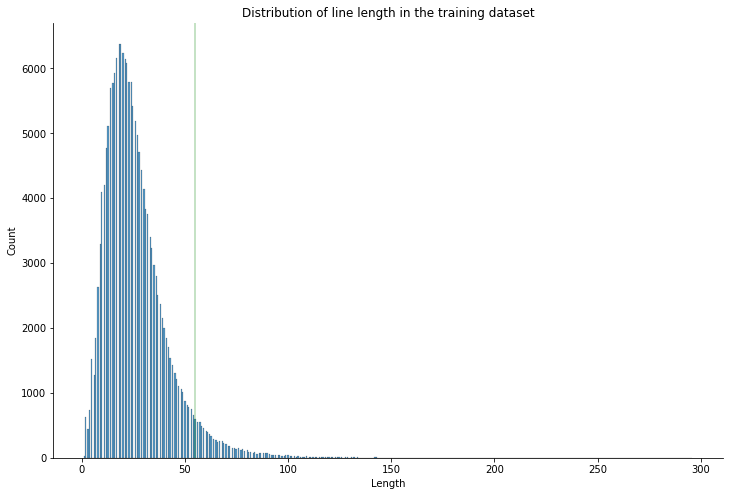

In [28]:
plt.figure(figsize=(12, 8))
sns.histplot(sentence_length)
sns.despine()
plt.axvline(sequence_length, c='g', alpha=0.3)
plt.title('Distribution of line length in the training dataset')
plt.xlabel('Length');

In [29]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000, output_sequence_length=sequence_length) # 68,000 is the vocabulary's size mentioned in the paper
text_vectorizer.adapt(train_sentences)

In [30]:
vocabulary = text_vectorizer.get_vocabulary()
print("5 most common tokens: {}".format(vocabulary[:5]))
print("5 least common tokens: {}".format(vocabulary[-5:]))
print("Number of tokens in 20k training dataset: {}".format(len(vocabulary)))

5 most common tokens: ['', '[UNK]', 'the', 'and', 'of']
5 least common tokens: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
Number of tokens in 20k training dataset: 64841


In [31]:
embed_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128)

Build the model

In [32]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='m1_input_layer')
text_vectorization = text_vectorizer(inputs)
word_embedding = embed_layer(text_vectorization)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same',
                           activation='relu')(word_embedding)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)), # train on subset to make training faster for initial experiments
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(train_dataset)),
                              callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                                     experiment_name='conv1d')])

Epoch 1/5
562/562 [==============================] - 16s 10ms/step - loss: 0.9106 - accuracy: 0.6393 - val_loss: 0.6809 - val_accuracy: 0.7442
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6559 - accuracy: 0.7563 - val_loss: 0.6354 - val_accuracy: 0.7739
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6161 - accuracy: 0.7739 - val_loss: 0.5912 - val_accuracy: 0.7910
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5882 - accuracy: 0.7889 - val_loss: 0.5713 - val_accuracy: 0.7974
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5913 - accuracy: 0.7915 - val_loss: 0.5553 - val_accuracy: 0.8031


In [33]:
model_1_preds_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)

In [34]:
model_1_results = calculate_results(y_true=labels_val,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.05759300940024,
 'precision': 0.8004908123046888,
 'recall': 0.8005759300940024,
 'f1': 0.7974397205081231}

**5.3 Feature extraction with pretrained token embeddings (transfer learning)**

Transfer learning is a great tool to improve performance by leveraging the learned patterns from complex models trained on big datasets.

For our task, we will replace the TextVectorization and word embedding layers with the Universal Sentence Encoder from TensorFlow Hub.

In [35]:
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                     trainable=False)

In [36]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='m2_input_layer')
use_embedding = use(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(use_embedding)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2')

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_2 = model_2.fit(train_dataset,
                  epochs=5,
                  validation_data=val_dataset,
                  steps_per_epoch=int(0.1*len(train_dataset)),
                  validation_steps=int(0.1*len(val_dataset)),
                  callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                         experiment_name='model_2')])

Epoch 1/5
562/562 [==============================] - 9s 11ms/step - loss: 0.9185 - accuracy: 0.6477 - val_loss: 0.7982 - val_accuracy: 0.6892
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7698 - accuracy: 0.7011 - val_loss: 0.7564 - val_accuracy: 0.7064
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7535 - accuracy: 0.7124 - val_loss: 0.7412 - val_accuracy: 0.7118
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7198 - accuracy: 0.7229 - val_loss: 0.7136 - val_accuracy: 0.7281
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7267 - accuracy: 0.7224 - val_loss: 0.6931 - val_accuracy: 0.7357


In [37]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)

In [38]:
model_2_results = calculate_results(y_true=labels_val,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.46418641599365,
 'precision': 0.7305488449786577,
 'recall': 0.7346418641599365,
 'f1': 0.728981268611325}

**5.4 Conv1D model with character-level tokenization**

Instead of tokenizing at the word level, let's see how well a model performs with character-level tokenization.

Before creating the datasets, we must preprocess the data to separate characters in each word to treat them independently

In [39]:
def split_chars(text):
  return " ".join(list(text))

In [40]:
char_train_sentences = [split_chars(sentence) for sentence in train_sentences]
char_val_sentences = [split_chars(sentence) for sentence in val_sentences]
char_test_sentences = [split_chars(sentence) for sentence in test_sentences]

char_train_sentences[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [41]:
char_train_dataset = tf.data.Dataset.from_tensor_slices((char_train_sentences, train_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)
char_val_dataset = tf.data.Dataset.from_tensor_slices((char_val_sentences, val_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)
char_test_dataset = tf.data.Dataset.from_tensor_slices((char_test_sentences, test_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
print("Total alphanumeric + punctuation characters: {}".format(len(all_chars))) # max_tokens input in new TextVectorization layer

Total alphanumeric + punctuation characters: 68


In [44]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=len(all_chars) + 2, output_sequence_length=sequence_length)
char_vectorizer.adapt(char_train_sentences)

In [45]:
characters = char_vectorizer.get_vocabulary()
print("5 most common tokens: {}".format(characters[:5]))
print("5 least common tokens: {}".format(characters[-5:]))
print("Number of tokens in 20k training dataset: {}".format(len(characters)))

5 most common tokens: ['', '[UNK]', 'e', 't', 'i']
5 least common tokens: ['k', 'x', 'z', 'q', 'j']
Number of tokens in 20k training dataset: 28


In [46]:
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()), output_dim=24, mask_zero=False)

In [47]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='m3_input_layer')
char_vector = char_vectorizer(inputs)
char_embed = char_embedding(char_vector)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same',
                           activation='relu')(char_embed)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3')

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.fit(char_train_dataset,
            epochs=5,
            steps_per_epoch=int(0.1*len(char_train_dataset)),
            validation_data=char_val_dataset,
            validation_steps=int(0.1*len(char_val_dataset)),
            callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                   experiment_name='model_3')])

Epoch 1/5
562/562 [==============================] - 3s 4ms/step - loss: 1.3107 - accuracy: 0.4552 - val_loss: 1.1491 - val_accuracy: 0.5356
Epoch 2/5
562/562 [==============================] - 2s 4ms/step - loss: 1.1112 - accuracy: 0.5460 - val_loss: 1.0487 - val_accuracy: 0.5838
Epoch 3/5
562/562 [==============================] - 2s 4ms/step - loss: 1.0340 - accuracy: 0.5840 - val_loss: 0.9816 - val_accuracy: 0.6174
Epoch 4/5
562/562 [==============================] - 2s 4ms/step - loss: 0.9871 - accuracy: 0.6064 - val_loss: 0.9586 - val_accuracy: 0.6283
Epoch 5/5
562/562 [==============================] - 2s 4ms/step - loss: 0.9681 - accuracy: 0.6172 - val_loss: 0.9342 - val_accuracy: 0.6423


In [48]:
model_3_preds_probs = model_3.predict(char_val_dataset)
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)

In [49]:
model_3_results = calculate_results(y_true=labels_val,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 62.759830530914876,
 'precision': 0.6215059219339926,
 'recall': 0.6275983053091487,
 'f1': 0.6185701404025754}

**5.5 Wide-and-deep model combining character and token embeddings**

The character-level embedding model didn't perform quite as well. However, it may contain some useful information for the problem. Let's test if joining both character and token embeddings improves the performance.

In [50]:
train_dataset_wad_x = tf.data.Dataset.from_tensor_slices((train_sentences, char_train_sentences))
train_dataset_wad_y = tf.data.Dataset.from_tensor_slices(train_labels_one_hot.toarray())
train_dataset_wad = tf.data.Dataset.zip((train_dataset_wad_x, train_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_wad_x = tf.data.Dataset.from_tensor_slices((val_sentences, char_val_sentences))
val_dataset_wad_y = tf.data.Dataset.from_tensor_slices(val_labels_one_hot.toarray())
val_dataset_wad = tf.data.Dataset.zip((val_dataset_wad_x, val_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_wad_x = tf.data.Dataset.from_tensor_slices((test_sentences, char_test_sentences))
test_dataset_wad_y = tf.data.Dataset.from_tensor_slices(test_labels_one_hot.toarray())
test_dataset_wad = tf.data.Dataset.zip((test_dataset_wad_x, test_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
# Sentence
inputs_sentence = tf.keras.layers.Input(shape=[], dtype=tf.string)
sentence_embedding = use(inputs_sentence)
x_sentence = tf.keras.layers.Dense(128, activation='relu')(sentence_embedding)
sentence_model = tf.keras.Model(inputs=inputs_sentence,
                                outputs=x_sentence)

# Character
inputs_char = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs_char)
char_embed = char_embedding(char_vector)
x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs=inputs_char,
                            outputs=x_char)

# Concatenate
conc_layer = tf.keras.layers.Concatenate()([sentence_model.output, 
                                            char_model.output])

# Dropout
last_dense = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(last_dense)

# Output
outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout_layer)

model_4 = tf.keras.Model(inputs=[inputs_sentence,
                                 inputs_char],
                         outputs=outputs,
                         name='model_4')

model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_4.fit(train_dataset_wad,
            epochs=5,
            validation_data=val_dataset_wad,
            validation_steps=int(0.1*len(val_dataset_wad)),
            steps_per_epoch=int(0.1*len(train_dataset_wad)),
            callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                   experiment_name='model_4')])

Epoch 1/5
562/562 [==============================] - 14s 18ms/step - loss: 0.9280 - accuracy: 0.6333 - val_loss: 0.7641 - val_accuracy: 0.7088
Epoch 2/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7512 - accuracy: 0.7147 - val_loss: 0.6948 - val_accuracy: 0.7337
Epoch 3/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7176 - accuracy: 0.7284 - val_loss: 0.6663 - val_accuracy: 0.7443
Epoch 4/5
562/562 [==============================] - 9s 15ms/step - loss: 0.6855 - accuracy: 0.7428 - val_loss: 0.6398 - val_accuracy: 0.7613
Epoch 5/5
562/562 [==============================] - 9s 15ms/step - loss: 0.6863 - accuracy: 0.7405 - val_loss: 0.6274 - val_accuracy: 0.7623


In [52]:
model_4_preds_probs = model_4.predict(val_dataset_wad)
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)

In [53]:
model_4_results = calculate_results(y_true=labels_val,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.6686084999338,
 'precision': 0.7531010201126918,
 'recall': 0.756686084999338,
 'f1': 0.7528374557461917}

**5.6 Wide and deep model including sentence position in abstract**

From the exploratory data analysis, we found out that there is a strong correlation between class label and line position. For our final experiment, we will include an additional input layer that provides the model information about the position of the line in the abstract.

Given that 90% of the abstracts have less than 17 lines, we will one-hot encode the line_number variable using a depth of 17. This will cover most of the data.

In [54]:
train_line_pos = tf.one_hot(train_df['line_number'].to_numpy(), depth=17)
val_line_pos = tf.one_hot(val_df['line_number'].to_numpy(), depth=17)
test_line_pos = tf.one_hot(test_df['line_number'].to_numpy(), depth=17)

In [55]:
train_dataset_wad_pos = tf.data.Dataset.from_tensor_slices((train_sentences, char_train_sentences, train_line_pos))
train_dataset_wad_pos = tf.data.Dataset.zip((train_dataset_wad_pos, train_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_wad_pos = tf.data.Dataset.from_tensor_slices((val_sentences, char_val_sentences, val_line_pos))
val_dataset_wad_pos = tf.data.Dataset.zip((val_dataset_wad_pos, val_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_wad_pos = tf.data.Dataset.from_tensor_slices((test_sentences, char_test_sentences, test_line_pos))
test_dataset_wad_pos = tf.data.Dataset.zip((test_dataset_wad_pos, test_dataset_wad_y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
# Token embeddings
inputs_sentence = tf.keras.layers.Input(shape=[], dtype=tf.string)
sentence_embedding = use(inputs_sentence)
x_sentence = tf.keras.layers.Dense(128, activation='relu')(sentence_embedding)
sentence_model = tf.keras.Model(inputs_sentence,
                                x_sentence)

# Character embeddings
inputs_char = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs_char)
char_embed = char_embedding(char_vector)
x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs_char,
                            x_char)

# Positional model
inputs_positional = tf.keras.layers.Input(shape=(17,), dtype=tf.int32)
x = tf.keras.layers.Dense(32, activation='relu')(inputs_positional)
positional_model = tf.keras.Model(inputs_positional, x)

# Concatenate
conc_layer = tf.keras.layers.Concatenate()([sentence_model.output,
                                            char_model.output,
                                            positional_model.output])
# Dropout
x_dense = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
dropout = tf.keras.layers.Dropout(0.5)(x_dense)

# Outputs
outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)

model_5 = tf.keras.Model([inputs_sentence, inputs_char, inputs_positional],
                         outputs)

model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.fit(train_dataset_wad_pos,
            epochs=5,
            validation_data=val_dataset_wad_pos,
            validation_steps=int(0.1*len(val_dataset_wad_pos)),
            steps_per_epoch=int(0.1*len(train_dataset_wad_pos)),
            callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                   experiment_name='model_5')])

Epoch 1/5
562/562 [==============================] - 13s 17ms/step - loss: 0.7334 - accuracy: 0.7174 - val_loss: 0.5226 - val_accuracy: 0.7979
Epoch 2/5
562/562 [==============================] - 9s 15ms/step - loss: 0.5102 - accuracy: 0.8044 - val_loss: 0.4660 - val_accuracy: 0.8208
Epoch 3/5
562/562 [==============================] - 9s 15ms/step - loss: 0.4858 - accuracy: 0.8091 - val_loss: 0.4539 - val_accuracy: 0.8268
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.4742 - accuracy: 0.8208 - val_loss: 0.4369 - val_accuracy: 0.8265
Epoch 5/5
562/562 [==============================] - 9s 15ms/step - loss: 0.4662 - accuracy: 0.8239 - val_loss: 0.4251 - val_accuracy: 0.8374


In [57]:
model_5_preds_probs = model_5.predict(val_dataset_wad_pos)
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)

In [58]:
model_5_results = calculate_results(y_true=labels_val,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.4569045412419,
 'precision': 0.837790060939425,
 'recall': 0.8345690454124189,
 'f1': 0.8314493356134944}

Finally, we'll compare the results of all models to see which one performed better

In [59]:
all_model_results = pd.concat([pd.DataFrame(baseline_results, index=['baseline_model']),
                    pd.DataFrame(model_1_results, index=['model_1']),
                    pd.DataFrame(model_2_results, index=['model_2']),
                    pd.DataFrame(model_3_results, index=['model_3']),
                    pd.DataFrame(model_4_results, index=['model_4']),
                    pd.DataFrame(model_5_results, index=['model_5'])], axis=0)
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
model_1,80.057593,0.800491,0.800576,0.797440
model_2,73.464186,0.730549,0.734642,0.728981
model_3,62.759831,0.621506,0.627598,0.618570
model_4,75.668608,0.753101,0.756686,0.752837
model_5,83.456905,0.837790,0.834569,0.831449


Model 5 is the best performing model, let's continue working on it. The model_1 with a Conv1D layer had a good performance as well. This architecture may convey useful information about the patterns found in the data. To test this, we'll replace the dense layer and the USE of the sentence_model with a Conv1D layer and text vectorization and word embedding layers.

In [60]:
# Token embeddings
inputs_sentence = tf.keras.layers.Input(shape=[], dtype=tf.string)
text_vectorization = text_vectorizer(inputs_sentence)
word_embedding = embed_layer(text_vectorization)
x_sentence = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same',
                                    activation='relu')(word_embedding)
x_sentence = tf.keras.layers.GlobalAveragePooling1D()(x_sentence)
sentence_model = tf.keras.Model(inputs_sentence,
                                x_sentence)

# Character embeddings
inputs_char = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs_char)
char_embed = char_embedding(char_vector)
x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs_char,
                            x_char)

# Positional model
inputs_positional = tf.keras.layers.Input(shape=(17,), dtype=tf.int32)
x = tf.keras.layers.Dense(32, activation='relu')(inputs_positional)
positional_model = tf.keras.Model(inputs_positional, x)

# Concatenate
conc_layer = tf.keras.layers.Concatenate()([sentence_model.output,
                                            char_model.output,
                                            positional_model.output])

# Dropout
x_dense = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
dropout = tf.keras.layers.Dropout(0.5)(x_dense)

# Outputs
outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)

model_6 = tf.keras.Model([inputs_sentence, inputs_char, inputs_positional],
                         outputs)

model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.fit(train_dataset_wad_pos,
            epochs=5,
            validation_data=val_dataset_wad_pos,
            validation_steps=int(0.1*len(val_dataset_wad_pos)),
            steps_per_epoch=int(0.1*len(train_dataset_wad_pos)),
            callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                   experiment_name='model_6')])

Epoch 1/5
562/562 [==============================] - 12s 15ms/step - loss: 0.5608 - accuracy: 0.7921 - val_loss: 0.4145 - val_accuracy: 0.8511
Epoch 2/5
562/562 [==============================] - 8s 13ms/step - loss: 0.3758 - accuracy: 0.8626 - val_loss: 0.3941 - val_accuracy: 0.8524
Epoch 3/5
562/562 [==============================] - 8s 13ms/step - loss: 0.3532 - accuracy: 0.8677 - val_loss: 0.3835 - val_accuracy: 0.8564
Epoch 4/5
562/562 [==============================] - 8s 13ms/step - loss: 0.3437 - accuracy: 0.8758 - val_loss: 0.3856 - val_accuracy: 0.8531
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.3429 - accuracy: 0.8770 - val_loss: 0.3784 - val_accuracy: 0.8587


In [61]:
model_6_preds_probs = model_6.predict(val_dataset_wad_pos)
model_6_preds = tf.argmax(model_6_preds_probs, axis=1)

In [62]:
model_6_results = calculate_results(y_true=labels_val,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 85.86985303852774,
 'precision': 0.8593556826153284,
 'recall': 0.8586985303852773,
 'f1': 0.8570625058485454}

In [63]:
all_model_results = pd.concat([all_model_results,
                               pd.DataFrame(model_6_results, index=['model_6'])], axis=0)
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
model_1,80.057593,0.800491,0.800576,0.797440
model_2,73.464186,0.730549,0.734642,0.728981
model_3,62.759831,0.621506,0.627598,0.618570
model_4,75.668608,0.753101,0.756686,0.752837
model_5,83.456905,0.837790,0.834569,0.831449
model_6,85.869853,0.859356,0.858699,0.857063


Great, the adjustment yielded a significant increase in the model's performance. 

Given that our dataset is imbalanced, let's see how the model performed classifying each class.

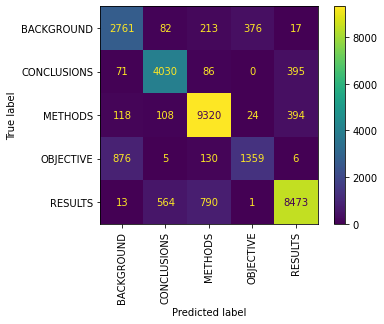

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(labels_val, model_6_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical');

Take a look at class imbalance

In [65]:
train_df['target'].value_counts() / train_df['target'].value_counts().sum()

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64

The "OBJECTIVE" class is the most underrepresented class. It is also the class with the most misclassifications. If we take a look at the confusion matrix, we can see that many times the model predicted "BACKGROUND" when it should have predicted "OBJECTIVE".

Let's try to improve this by assigning class weights to the neural network.

In [66]:
class_weights = train_df['target'].value_counts() / train_df['target'].value_counts().sum()
class_weights = 1 / class_weights
class_weights /= class_weights.sum()
class_weights = class_weights.loc[encoder.categories_[0]]
class_weights = {k: v for k, v in zip(range(len(class_weights)), class_weights.values)}
class_weights

{0: 0.24326861683112658,
 1: 0.19454863213670082,
 2: 0.0890518969199516,
 3: 0.38192768537393507,
 4: 0.091203168738286}

In [67]:
# Token embeddings
inputs_sentence = tf.keras.layers.Input(shape=[], dtype=tf.string)
text_vectorization = text_vectorizer(inputs_sentence)
word_embedding = embed_layer(text_vectorization)
x_sentence = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same',
                                    activation='relu')(word_embedding)
x_sentence = tf.keras.layers.GlobalAveragePooling1D()(x_sentence)
sentence_model = tf.keras.Model(inputs_sentence,
                                x_sentence)

# Character embeddings
inputs_char = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs_char)
char_embed = char_embedding(char_vector)
x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model = tf.keras.Model(inputs_char,
                            x_char)

# Positional model
inputs_positional = tf.keras.layers.Input(shape=(17,), dtype=tf.int32)
x = tf.keras.layers.Dense(32, activation='relu')(inputs_positional)
positional_model = tf.keras.Model(inputs_positional, x)

# Concatenate
conc_layer = tf.keras.layers.Concatenate()([sentence_model.output,
                                            char_model.output,
                                            positional_model.output])

# Dropout
x_dense = tf.keras.layers.Dense(128, activation='relu')(conc_layer)
dropout = tf.keras.layers.Dropout(0.5)(x_dense)

# Outputs
outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)

model_7 = tf.keras.Model([inputs_sentence, inputs_char, inputs_positional],
                         outputs)

model_7.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7.fit(train_dataset_wad_pos,
            epochs=5,
            validation_data=val_dataset_wad_pos,
            validation_steps=int(0.1*len(val_dataset_wad_pos)),
            steps_per_epoch=int(0.1*len(train_dataset_wad_pos)),
            callbacks=[create_tensorboard_callback(dir_name='tb_callbacks',
                                                   experiment_name='model_7')],
            class_weight=class_weights) # assign class weights to tackle the imbalanced problm

Epoch 1/5
562/562 [==============================] - 12s 15ms/step - loss: 0.0904 - accuracy: 0.7987 - val_loss: 0.4583 - val_accuracy: 0.8428
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.0572 - accuracy: 0.8786 - val_loss: 0.4482 - val_accuracy: 0.8351
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.0544 - accuracy: 0.8854 - val_loss: 0.4448 - val_accuracy: 0.8318
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.0519 - accuracy: 0.8904 - val_loss: 0.4103 - val_accuracy: 0.8521
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.0504 - accuracy: 0.8952 - val_loss: 0.4237 - val_accuracy: 0.8424


In [68]:
model_7_preds_probs = model_7.predict(val_dataset_wad_pos)
model_7_preds = tf.argmax(model_7_preds_probs, axis=1)

In [69]:
model_7_results = calculate_results(y_true=labels_val,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 84.0129749768304,
 'precision': 0.843446133707912,
 'recall': 0.840129749768304,
 'f1': 0.8404820752186453}

In [70]:
all_model_results = pd.concat([all_model_results,
                               pd.DataFrame(model_7_results, index=['model_7'])], axis=0)
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
model_1,80.057593,0.800491,0.800576,0.797440
model_2,73.464186,0.730549,0.734642,0.728981
model_3,62.759831,0.621506,0.627598,0.618570
model_4,75.668608,0.753101,0.756686,0.752837
model_5,83.456905,0.837790,0.834569,0.831449
model_6,85.869853,0.859356,0.858699,0.857063
model_7,84.012975,0.843446,0.840130,0.840482


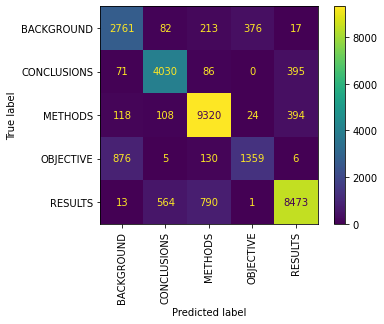

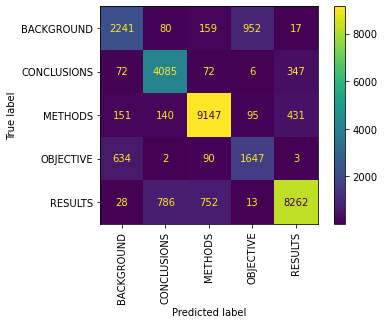

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm_ovs = confusion_matrix(labels_val, model_7_preds)
disp_ovs = ConfusionMatrixDisplay(cm_ovs, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical')
disp_ovs.plot(xticks_rotation='vertical');

Even though the OBJECTIVE class had a higher precision, other classes such as RESULTS and BACKGROUND were negatively impacted. For further experiments, we can try oversampling the classes.

**6. Fine tuning**

Model 6 was the best performing model. We will proceed to fine-tune it to see if we can improve performance.

In [73]:
import keras_tuner

In [74]:
def build_model(hp):
  # Token embeddings
  inputs_sentence = tf.keras.layers.Input(shape=[], dtype=tf.string)
  text_vectorization = text_vectorizer(inputs_sentence)
  word_embedding = embed_layer(text_vectorization)
  x_sentence = tf.keras.layers.Conv1D(filters=hp.Choice('conv1d_filters', [16, 32, 64, 128]), kernel_size=hp.Choice('conv1d_ksize', [3, 5, 7]), padding='same',
                                      activation=hp.Choice('conv1d_activation', ['relu', 'elu', 'tanh']))(word_embedding)
  x_sentence = tf.keras.layers.GlobalAveragePooling1D()(x_sentence)
  sentence_model = tf.keras.Model(inputs_sentence,
                                  x_sentence)

  # Character embeddings
  inputs_char = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
  char_vector = char_vectorizer(inputs_char)
  char_embed = char_embedding(char_vector)
  x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Choice('lstm_units', [24, 48, 96])))(char_embed)
  char_model = tf.keras.Model(inputs_char,
                              x_char)

  # Positional model
  inputs_positional = tf.keras.layers.Input(shape=(17,), dtype=tf.int32)
  x = tf.keras.layers.Dense(hp.Choice('dense1_units', [16, 32, 64, 128]), activation=hp.Choice('dense1_activation', ['relu', 'elu']))(inputs_positional)
  positional_model = tf.keras.Model(inputs_positional, x)

  # Concatenate
  conc_layer = tf.keras.layers.Concatenate()([sentence_model.output,
                                              char_model.output,
                                              positional_model.output])

  # Dropout
  x_dense = tf.keras.layers.Dense(hp.Choice('dense2_units', [16, 32, 64, 128]), activation=hp.Choice('dense2_activation', ['relu', 'elu']))(conc_layer)
  dropout = tf.keras.layers.Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.5]))(x_dense)

  # Outputs
  outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)

  model = tf.keras.Model([inputs_sentence, inputs_char, inputs_positional],
                          outputs)
  model.compile(loss='categorical_crossentropy',
                optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'nadam']),
                metrics=['accuracy'])

  return model

In [75]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=25,
    directory='keras_tuner_dir/',
    project_name='paper_classification')

In [76]:
tuner.search(train_dataset_wad_pos, epochs=5, validation_data=val_dataset_wad_pos)

Trial 25 Complete [00h 06m 28s]
val_loss: 1.7348905801773071

Best val_loss So Far: 0.39833948016166687
Total elapsed time: 02h 31m 20s


In [87]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/paper_classification
Showing 10 best trials
Trial summary
Hyperparameters:
conv1d_filters: 16
conv1d_ksize: 3
conv1d_activation: tanh
lstm_units: 96
dense1_units: 32
dense1_activation: elu
dense2_units: 64
dense2_activation: relu
dropout_rate: 0.3
optimizer: adam
Score: 0.39833948016166687
Trial summary
Hyperparameters:
conv1d_filters: 64
conv1d_ksize: 5
conv1d_activation: relu
lstm_units: 24
dense1_units: 64
dense1_activation: relu
dense2_units: 128
dense2_activation: elu
dropout_rate: 0.3
optimizer: sgd
Score: 0.4478137493133545
Trial summary
Hyperparameters:
conv1d_filters: 128
conv1d_ksize: 7
conv1d_activation: relu
lstm_units: 24
dense1_units: 32
dense1_activation: elu
dense2_units: 32
dense2_activation: relu
dropout_rate: 0.3
optimizer: sgd
Score: 0.473442405462265
Trial summary
Hyperparameters:
conv1d_filters: 64
conv1d_ksize: 7
conv1d_activation: relu
lstm_units: 96
dense1_units: 64
dense1_activation: elu
dense2_units: 64
dense2_activa

In [126]:
model_8 = build_model(tuner.get_best_hyperparameters()[0])

Lets find the optimal learning rate for this model

In [103]:
K = tf.keras.backend
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model_iter, train, epochs=1, min_rate=10**-5, max_rate=10, iterations=None):
    init_weights = model_iter.get_weights()
    iterations = len(train) * epochs if iterations is None else iterations
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model_iter.optimizer.learning_rate)
    K.set_value(model_iter.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model_iter.fit(train, epochs=epochs, callbacks=[exp_lr])
    K.set_value(model_iter.optimizer.learning_rate, init_lr)
    model_iter.set_weights(init_weights)
    plot_lr_vs_loss(exp_lr.rates, exp_lr.losses)
    K.clear_session()

def plot_lr_vs_loss(rates, losses):
    min_pos = np.where(losses == np.min(losses))[0][0]
    min_rate = rates[min_pos]
    title="Min learning rate: {}".format(min_rate)
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.title(title)
    plt.axvline(x=min_rate, c='g', alpha=0.5)
    plt.show()
    plt.clf();

5627/5627 [==============================] - 80s 14ms/step - loss: 2.4640 - accuracy: 0.5634


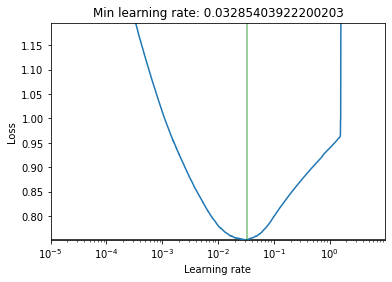

<Figure size 432x288 with 0 Axes>

In [96]:
find_learning_rate(model_8, train_dataset_wad_pos)

0.01 seems like an appropriate learning rate

Finally, we'll define some callbacks

In [127]:
N_EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_8_chpt/model_8', save_best_only=True, monitor='val_loss',
                                                      save_weights_only=True)
tb_callback = create_tensorboard_callback(dir_name='tb_callbacks', experiment_name='model_8')

In [128]:
model_8.compile(loss='categorical_crossentropy',
                metrics=['accuracy'], 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-5))

history_m8 = model_8.fit(train_dataset_wad_pos, epochs=N_EPOCHS, validation_data=val_dataset_wad_pos,
                      callbacks=[model_checkpoint, tb_callback, early_stopping])

Epoch 1/100
5627/5627 [==============================] - 79s 13ms/step - loss: 0.5123 - accuracy: 0.8040 - val_loss: 0.4961 - val_accuracy: 0.8165
Epoch 2/100
5627/5627 [==============================] - 75s 13ms/step - loss: 0.4680 - accuracy: 0.8256 - val_loss: 0.4766 - val_accuracy: 0.8261
Epoch 3/100
5627/5627 [==============================] - 74s 13ms/step - loss: 0.4571 - accuracy: 0.8316 - val_loss: 0.4836 - val_accuracy: 0.8293
Epoch 4/100
5627/5627 [==============================] - 75s 13ms/step - loss: 0.4510 - accuracy: 0.8316 - val_loss: 0.4821 - val_accuracy: 0.8286
Epoch 5/100
5627/5627 [==============================] - 74s 13ms/step - loss: 0.4424 - accuracy: 0.8363 - val_loss: 0.4840 - val_accuracy: 0.8273
Epoch 6/100
5627/5627 [==============================] - 75s 13ms/step - loss: 0.4375 - accuracy: 0.8385 - val_loss: 0.4696 - val_accuracy: 0.8343
Epoch 7/100
5627/5627 [==============================] - 75s 13ms/step - loss: 0.4312 - accuracy: 0.8404 - val_loss: 0

In [129]:
model_8_preds_probs = model_8.predict(val_dataset_wad_pos)
model_8_preds = tf.argmax(model_8_preds_probs, axis=1)

In [130]:
model_8_results = calculate_results(y_true=labels_val,
                                    y_pred=model_8_preds)
model_8_results

{'accuracy': 85.0158877267311,
 'precision': 0.8531088135946695,
 'recall': 0.850158877267311,
 'f1': 0.846733674896619}

In [138]:
all_model_results = pd.concat([all_model_results,
                               pd.DataFrame(model_8_results, index=['model_8'])], axis=0)
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
model_1,80.057593,0.800491,0.800576,0.797440
model_2,73.464186,0.730549,0.734642,0.728981
model_3,62.759831,0.621506,0.627598,0.618570
model_4,75.668608,0.753101,0.756686,0.752837
model_5,83.456905,0.837790,0.834569,0.831449
model_6,85.869853,0.859356,0.858699,0.857063
model_7,84.012975,0.843446,0.840130,0.840482
model_8,85.015888,0.853109,0.850159,0.846734


Great! We managed to slightly improve all metrics with model 8.

Finally, lets test our model on the test set

In [139]:
model_8_preds_probs_test = model_8.predict(test_dataset_wad_pos)
model_8_preds_test = tf.argmax(model_8_preds_probs_test, axis=1)

In [140]:
model_8_results = calculate_results(y_true=labels_test,
                                    y_pred=model_8_preds_test)
model_8_results

{'accuracy': 84.7054919528787,
 'precision': 0.848931103404574,
 'recall': 0.8470549195287871,
 'f1': 0.8434298385820616}

Performance on the test set is very similar to that on the validation set. We have a good performing model which significantly outperformed our baseline model.

For further experiments, we could fit this model on the complete dataset.